## Import library

In [1]:
# importing required libraries
import os, sys
import sys
sys.path.insert(1, '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib')
sys.path.insert(1, '/home/dtd/Documents/interpretable_machine_learning/Causal Inference/CEA')


import numpy as np
import pandas as pd
import logging
import dowhy.datasets
import dowhy
import propensity_score_estimator as pse
import incremental_ps_score_estimator as ipse
import math 
import timeit
from scipy.stats import sem

from dowhy import CausalModel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
import evaluation as evl

In [2]:
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ]
cov = ["x" + str(i) for i in range(1,26)]
col = col + cov
features = cov + ["treatment"]

In [3]:
delta_seq = np.linspace(0.5, 10, 50)
treatment = 'treatment'
outcome = 'y_factual'

In [4]:
DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(1)
data = pd.read_csv(DATA_PATH, header = None, names = col)

In [5]:
data

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,0,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,...,1,0,1,0,0,0,0,0,0,0
743,1,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,0.808706,...,1,1,1,0,0,0,0,0,0,0
744,0,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,0.746189,...,1,1,1,0,0,0,0,0,0,0
745,0,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,...,1,1,1,0,0,0,0,0,0,0


In [8]:
# Create a causal model from the data and given graph.
model = CausalModel(data=data,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['y_factual']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


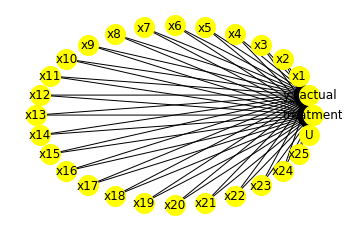

In [10]:
model.view_model()


## Do experiment 

### Z-estimator

In [6]:
def experiment_z_estimator(data, treatment, cov, outcome, estimator, delta_seq):
    ## Fit treatment 
    model_t = LogisticRegression()
    model_t.fit(data[cov], data[treatment])

    ## Fit outcome
    model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
    model_y.fit(data[features], data[outcome]) 
    
    ## Calculate causal effect ipse.z_estimator
    if estimator == 'z_estimator':
        estimation_effect = ipse.z_estimator(data, treatment, cov, outcome, delta_seq, model_t, model_y)
    elif estimator == 'simple_estimator':
        estimation_effect = ipse.simple_estimator(data, treatment, cov, outcome, model_t, model_y, delta = 2)
    true_effect = np.mean(data['mu1'] - data['mu0'])
     
    del model_t, model_y
    
    return evl.mae_ate(true_effect, estimation_effect)

In [7]:
z_estimator_mae = []
for i in tqdm(range(1,11)):
    DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(i)
    data = pd.read_csv(DATA_PATH, header = None, names = col)
    estimator = 'z_estimator'
    mae = experiment_z_estimator(data, treatment, cov, outcome, estimator, delta_seq)
    z_estimator_mae.append(mae)
    del data

100%|██████████| 10/10 [00:59<00:00,  5.98s/it]


In [15]:
z_estimator_mae

In [8]:
means, stds = np.mean(z_estimator_mae, axis=0), sem(z_estimator_mae, axis=0)
print('Z-estimator MAE: {:.3f}+-{:.3f}'.format(means, stds))

Z-estimator MAE: 6.617+-3.269


In [9]:
simple_estimator_mae = []
for i in tqdm(range(1,11)):
    DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(i)
    data = pd.read_csv(DATA_PATH, header = None, names = col)
    estimator = 'simple_estimator'
    mae = experiment_z_estimator(data, treatment, cov, outcome, estimator, delta_seq)
    simple_estimator_mae.append(mae)
    del data

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


In [10]:
means, stds = np.mean(simple_estimator_mae, axis=0), sem(simple_estimator_mae, axis=0)
print('Simple estimator MAE: {:.3f}+-{:.3f}'.format(means, stds))

Simple estimator MAE: 6.217+-3.123


In [11]:
simple_estimator_mae

### Dowhy package

In [ ]:
10 datasets

In [12]:
linear_mae = []
ps_matching = []
ps_stratification = []
ps_weighting = []

for i in tqdm(range(1,11)):
    DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(i)
    data = pd.read_csv(DATA_PATH, header = None, names = col)
    data['treatment'] = [bool(x) for x in data['treatment']]
    true_effect = np.mean(data['mu1'] - data['mu0'])
    
    
    model=CausalModel(
            data = data,
            treatment='treatment',
            outcome='y_factual',
            common_causes=cov,
            proceed_when_unidentifiable=True
            )

    identified_estimand = model.identify_effect()

    estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.linear_regression", test_significance=True
    )
    mae = abs(estimate.value - true_effect)
    linear_mae.append(mae)
    
    estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_matching"
    )
    mae = abs(estimate.value - true_effect)
    ps_matching.append(mae)


    estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_stratification", method_params={'num_strata':50, 'clipping_threshold':5}
    )
    mae = abs(estimate.value - true_effect)
    ps_stratification.append(mae)


    estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_weighting"
    )
    mae = abs(estimate.value - true_effect)
    ps_weighting.append(mae)



  0%|          | 0/10 [00:00<?, ?it/s]WARNING:dowhy.causal_model:Causal Graph not provided. DoWhy will construct a graph based on data inputs.
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['y_factual']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['x17', 'x11', 'x18', 'x19', 'x21', 'x2', 'x8', 'x23', 'x24', 'U', 'x10', 'x14', 'x25', 'x9', 'x4', 'x15', 'x20', 'x1', 'x13', 'x22', 'x16', 'x12', 'x5', 'x6', 'x7', 'x3']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y_factua

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     78.91
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          6.10e-191
Time:                        09:44:12   Log-Likelihood:                -1138.1
No. Observations:                 747   AIC:                             2330.
Df Residuals:                     720   BIC:                             2455.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2206      0.448      4.957      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     80.18
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          8.88e-193
Time:                        09:44:13   Log-Likelihood:                -1101.5
No. Observations:                 747   AIC:                             2257.
Df Residuals:                     720   BIC:                             2382.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4382      0.427      8.061      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     95.07
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          8.74e-213
Time:                        09:44:14   Log-Likelihood:                -1120.2
No. Observations:                 747   AIC:                             2294.
Df Residuals:                     720   BIC:                             2419.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0139      0.437      6.891      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     122.9
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          1.90e-244
Time:                        09:44:15   Log-Likelihood:                -1193.3
No. Observations:                 747   AIC:                             2441.
Df Residuals:                     720   BIC:                             2565.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6418      0.482      7.551      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     100.9
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          5.46e-220
Time:                        09:44:15   Log-Likelihood:                -1376.9
No. Observations:                 747   AIC:                             2808.
Df Residuals:                     720   BIC:                             2932.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3732      0.617     -2.227      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     96.01
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          5.74e-214
Time:                        09:44:16   Log-Likelihood:                -1092.3
No. Observations:                 747   AIC:                             2239.
Df Residuals:                     720   BIC:                             2363.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2275      0.421      2.913      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     74.17
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          6.43e-184
Time:                        09:44:17   Log-Likelihood:                -1051.5
No. Observations:                 747   AIC:                             2157.
Df Residuals:                     720   BIC:                             2282.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7186      0.399      4.308      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     77.94
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          1.58e-189
Time:                        09:44:17   Log-Likelihood:                -1273.2
No. Observations:                 747   AIC:                             2600.
Df Residuals:                     720   BIC:                             2725.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3494      0.537      2.514      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     67.72
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          7.98e-174
Time:                        09:44:18   Log-Likelihood:                -3006.9
No. Observations:                 747   AIC:                             6068.
Df Residuals:                     720   BIC:                             6193.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9878      5.467      2.376      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     92.48
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          1.76e-209
Time:                        09:44:19   Log-Likelihood:                -2124.9
No. Observations:                 747   AIC:                             4304.
Df Residuals:                     720   BIC:                             4428.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8970      1.679      3.513      0.0

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x17+x11+x18+x19+x21+x2+x8+x23+x24+x10+x14+x25+x9+x4+x15+x20+x1+x13+x22+x16+x12+x5+x6+x7+x3
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

In [23]:
z_estimator_mae

In [22]:
means, stds = np.mean(z_estimator_mae, axis=0), sem(z_estimator_mae, axis=0)
print('Z-estimator MAE: {:.3f}+-{:.3f}'.format(means, stds))

means, stds = np.mean(linear_mae, axis=0), sem(linear_mae, axis=0)
print('Linear MAE: {:.3f}+-{:.3f}'.format(means, stds))

means, stds = np.mean(ps_matching, axis=0), sem(ps_matching, axis=0)
print('K-nearest matching MAE: {:.3f}+-{:.3f}'.format(means, stds))

means, stds = np.mean(ps_stratification, axis=0), sem(ps_stratification, axis=0)
print('Stratification MAE: {:.3f}+-{:.3f}'.format(means, stds))

means, stds = np.mean(ps_weighting, axis=0), sem(ps_weighting, axis=0)
print('Weighting MAE: {:.3f}+-{:.3f}'.format(means, stds))

means, stds = np.mean(simple_estimator_mae, axis=0), sem(simple_estimator_mae, axis=0)
print('Simple estimator MAE: {:.3f}+-{:.3f}'.format(means, stds))

Z-estimator MAE: 6.617+-3.269
Linear MAE: 0.742+-0.554
K-nearest matching MAE: 0.144+-0.040
Stratification MAE: 2.424+-1.707
Weighting MAE: 1.401+-0.455
Simple estimator MAE: 6.217+-3.123


In [16]:
ps_matching

In [17]:
ps_stratification

In [18]:
ps_weighting

In [19]:
z_estimator_mae

In [24]:
DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(3)
data3 = pd.read_csv(DATA_PATH, header = None, names = col)
data3.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.931652,3.500591,2.253801,7.136441,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,2.175966,5.952101,1.257592,6.553022,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.180294,7.175734,2.384100,7.192645,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,3.587662,7.787537,4.009365,7.712456,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,2.372618,5.461871,2.481631,7.232739,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [25]:
data3.shape

In [26]:
DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(9)
data9 = pd.read_csv(DATA_PATH, header = None, names = col)
data9.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [27]:
DATA_PATH = "/home/dtd/Documents/interpretable_machine_learning/Source Code/data/datasets/IHDP/csv/ihdp_npci_{}.csv".format(10)
data10 = pd.read_csv(DATA_PATH, header = None, names = col)
data10.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,24.534220,19.525653,21.221590,24.830999,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,22.981254,26.063482,21.354089,24.837223,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,16.006497,23.937630,18.040368,24.668592,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,24.243270,23.527574,25.759277,25.024775,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,38.693296,25.436166,38.671451,25.431081,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


## Reference
https://microsoft.github.io/dowhy/dowhy_ihdp_data_example.html